In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

In [2]:
text_file = 'Voina.htm'
with open(text_file, 'r', encoding='koi8-r') as f:
        text = f.read().lower()
text = re.sub('[^а-яё ]','', text)

In [3]:
RUSSIAN = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '
POS = {l: i for i, l in enumerate(RUSSIAN)}
probabilities = np.zeros((len(RUSSIAN), len(RUSSIAN)))

In [4]:
for cp, cn in zip(text[:-1], text[1:]):
    try:
        probabilities[POS[cp], POS[cn]] += 1
    except:
        continue

In [5]:
#Checking for zero sum
prob_sum = probabilities.sum(axis=1)
for i, num in enumerate(prob_sum):
    if num == 0:
        prob_sum[i] = 1
#         print(i)

In [6]:
probabilities = (probabilities / prob_sum[:, None])
df = pd.DataFrame(probabilities, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))

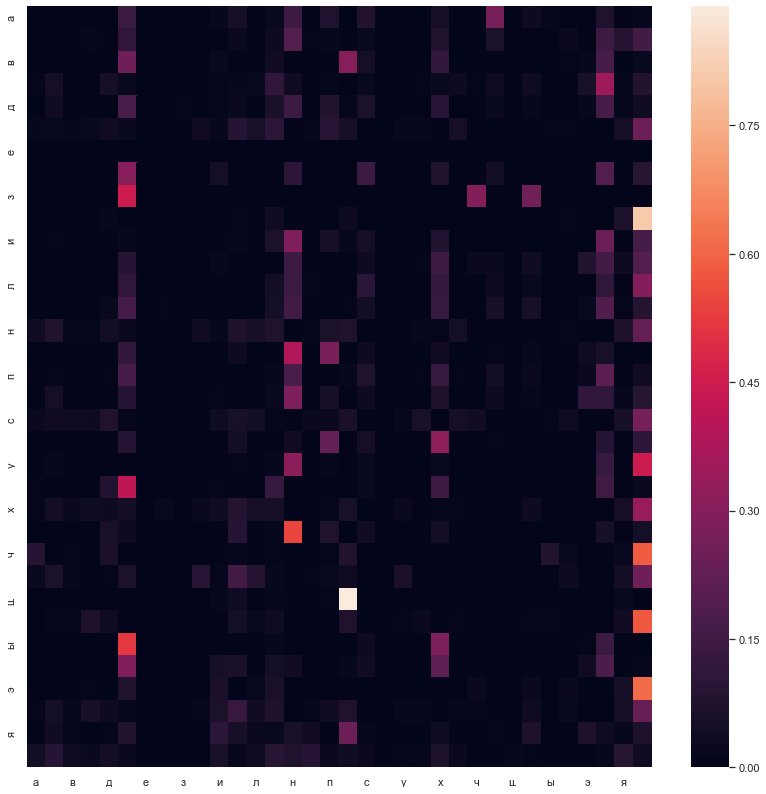

In [7]:
plt.figure(figsize=(14,14))
sns.heatmap(df, xticklabels=2, yticklabels=2)
plt.show()

In [8]:
#Generating string
s = []
start = np.random.choice(list(RUSSIAN))
s.append(start)
length = 10
for i in range(length):
    index = POS[s[i]]
    next_char = np.random.choice(list(RUSSIAN), p=probabilities[index])
    s.append(next_char)

print (''.join(s))

яйнелерэ д 


In [9]:
def count_proba(start_char, end_char, length=5, p=probabilities, index=POS, letters=RUSSIAN):
    """Recursive function to calculate probability of string."""
    prob_sum = 0
    
    #Length check
    if length < 2:
        return 1
    elif length == 2:
        return  p[index[start_char]][index[end_char]]

    
    for i in range(len(letters)):
        cur_p = p[index[start_char]][index[letters[i]]] * count_proba(letters[i], end_char, length-1, p, index, letters)
        prob_sum += cur_p
        
    return prob_sum

In [10]:
count_proba('п', 'р', length=4, p=probabilities, index=POS, letters=RUSSIAN)

0.039526747781440635

# HMM

In [11]:
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM

In [12]:
series = pd.read_csv('building_42.csv', header=None)[1]

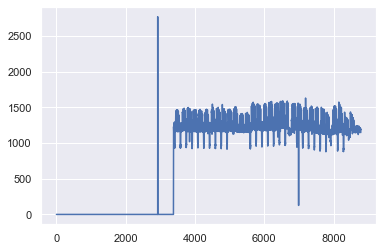

In [13]:
plt.plot(series)

In [14]:
series = series[3500:].values.reshape(-1, 1)

In [15]:
scores = []
for n in range(1, 24):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000, random_state=42)
    model.fit(series)
    scores.append(model.score(series))
    print (n, scores[-1])

1 -33761.34190482722
2 -31980.053688515924
3 -30263.600128246337
4 -29188.0358496067
5 -28536.810134379673
6 -28154.942028280682
7 -28029.317578094517
8 -27683.00463043158
9 -27324.18849082049
10 -27032.422617776083
11 -26829.586876611782
12 -26614.281965206243
13 -26478.70923989224
14 -26355.47925169332
15 -26144.35536617018
16 -26207.688596185853
17 -25920.648773716694
18 -25846.86028198029
19 -25791.6231546561
20 -25720.8893218255
21 -25527.87851913858
22 -25385.799925744206
23 -25233.450550883666


Run results - no need to re-run
1 -33761.34190482722
2 -31980.053688515924
3 -30263.600128246337
4 -29188.0358496067
5 -28536.810134379673
6 -28154.942028280682
7 -28029.317578094517
8 -27683.00463043158
9 -27324.18849082049
10 -27032.422617776083
11 -26829.586876611782
12 -26614.281965206243
13 -26478.70923989224
14 -26355.47925169332
15 -26144.35536617018
16 -26207.688596185853
17 -25920.648773716694
18 -25846.86028198029
19 -25791.6231546561
20 -25720.8893218255
21 -25527.87851913858
22 -25385.799925744206
23 -25233.450550883666

In [16]:
# diff = np.diff(scores)
second_der = np.r_[0, np.diff(scores, 2)]

<Figure size 1008x576 with 0 Axes>

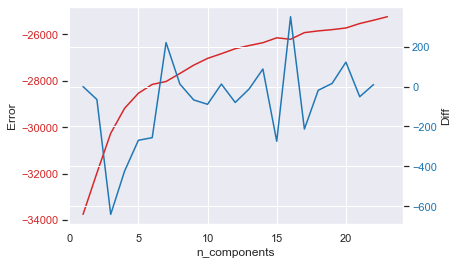

In [17]:
plt.figure(figsize=(14,8))
fig, ax1 = plt.subplots()
x = range(1, 24)

color = 'tab:red'
ax1.set_xlabel('n_components')
ax1.set_ylabel('Error')
ax1.plot(x, scores, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False, axis='y')

x = range(1, 23)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Diff')
ax2.plot(x, second_der, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(True, axis='y')

plt.show()

Первая точка перегиба при 6-ти компонентах - их и будем использовать

In [18]:
model = GaussianHMM(n_components=6, covariance_type="diag", n_iter=1000, random_state=42)
model.fit(series)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=1000, params='stmc',
            random_state=42, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
            verbose=False)

In [19]:
#Select subset of series - better plots
sub = series[3141:3241]

In [20]:
labels = model.predict(sub)
values = np.zeros_like(labels)

for i in range(model.n_components):
    values[labels == i] = model.means_[i]

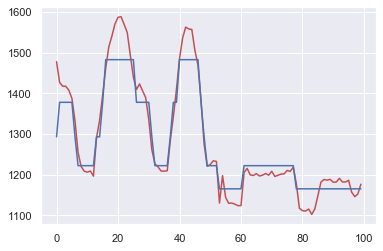

In [21]:
plt.plot(sub, 'r')
plt.plot(values, 'b')
plt.show()

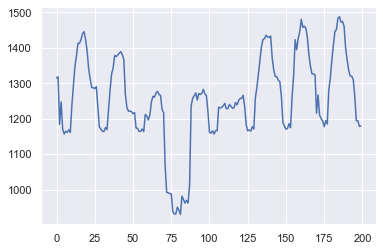

In [22]:
#Lets predict :)
sub = series[:200]
plt.plot(sub)
plt.show()

In [23]:
init_class = list(model.predict(sub[0].reshape(-1,1)))
init_class

[3]

In [24]:
values = [model.means_[init_class]]
classes = [i for i in range(model.n_components)]

for i in range(1, len(sub)):
    cur_class = np.random.choice(classes, p=model.transmat_[init_class[-1]])
    init_class.append(cur_class)
    values.append(model.means_[cur_class])

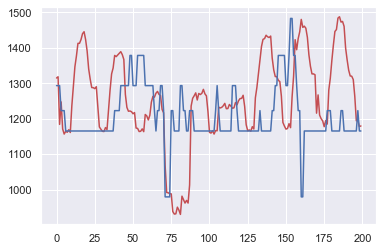

In [25]:
plt.plot(sub, 'r')
plt.plot(values, 'b')
plt.show()

## Куда-то попали, но точным прогнозом это вряд ли можно назвать))